In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from itertools import product

In [9]:
# 1. Iris veri setini yükle
iris = datasets.load_iris()
X, y = iris.data, iris.target
target_names = iris.target_names
n_classes = len(np.unique(y))

In [10]:
# 2. Verileri eğitim (%80) ve test (%20) olacak şekilde ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# 3. DVM parametrelerini tanımla
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10]
gamma_values = ['scale', 'auto', 0.1, 1]

In [12]:
# 4. Model eğitimi ve değerlendirme için döngü
results = []
for kernel, C, gamma in product(kernels, C_values, gamma_values):
    try:
        # Modeli tanımla ve eğit
        model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)
        model.fit(X_train, y_train)

        # Test kümesinde tahmin yap
        y_pred = model.predict(X_test)
        y_score = model.decision_function(X_test)

        # Performans metriklerini hesapla
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

        results.append({
            'Kernel': kernel,
            'C': C,
            'Gamma': gamma,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    except Exception as e:
        print(f"Model Error - Kernel: {kernel}, C: {C}, Gamma: {gamma}: {str(e)}")


In [13]:
# En iyi sonucu seç
results_df = pd.DataFrame(results)
best_model = results_df.iloc[results_df['Accuracy'].idxmax()]
print("En İyi Model:")
print(best_model)

En İyi Model:
Kernel       linear
C               0.1
Gamma         scale
Accuracy        1.0
Precision       1.0
Recall          1.0
F1 Score        1.0
Name: 0, dtype: object


In [14]:
# En iyi parametrelerle tekrar eğit
model = SVC(kernel=best_model['Kernel'], C=best_model['C'], gamma=best_model['Gamma'],
            probability=True, random_state=42)
model.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=42)

In [15]:
# Test kümesi tahminleri
y_pred = model.predict(X_test)
y_score = model.decision_function(X_test)

In [16]:
# Performans Metrikleri
print("\nSınıflandırma Performans Metrikleri:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Sınıflandırma Performans Metrikleri:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


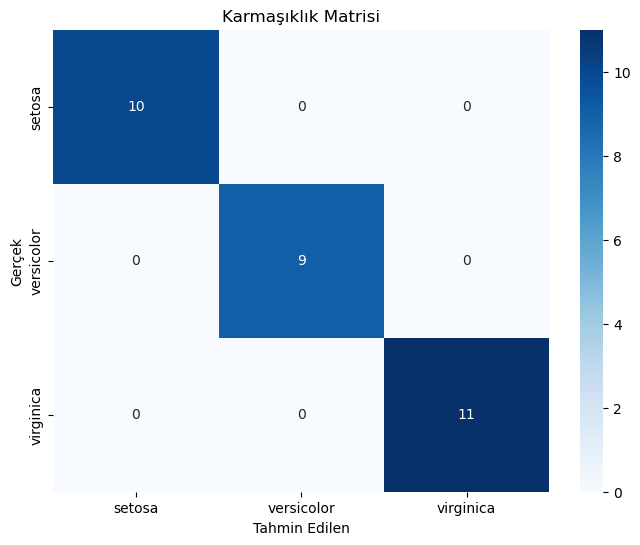

In [17]:
# Karmaşıklık Matrisi Görselleştirme
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=target_names, yticklabels=target_names)
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()


In [18]:
# ROC Eğrisi
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
fpr = {}
tpr = {}
roc_auc = {}


In [19]:
# Her sınıf için ROC eğrisi hesapla
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [20]:
# Ortalama ROC eğrisi
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
mean_auc = auc(all_fpr, mean_tpr)


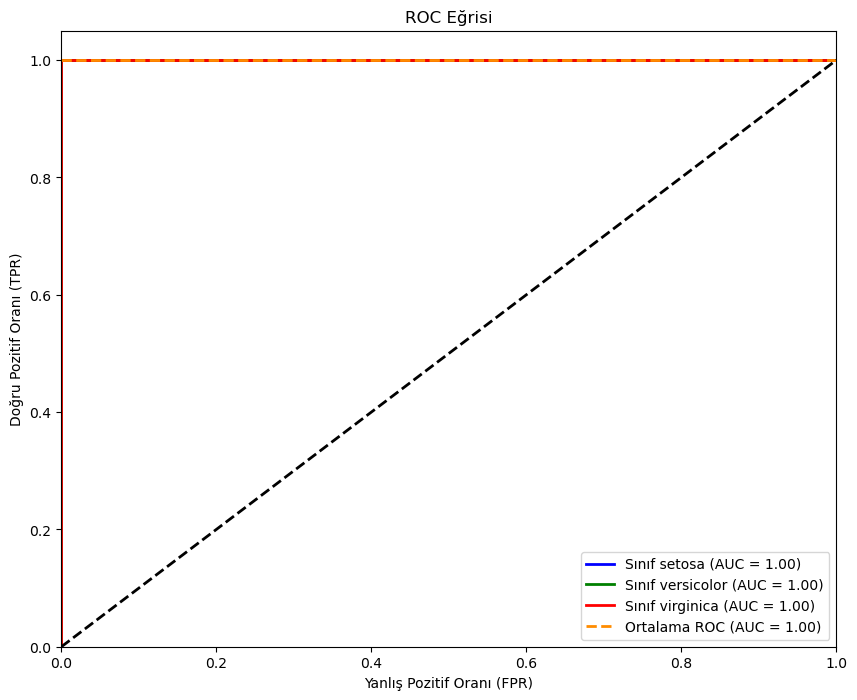

In [21]:
# ROC Eğrisi Çizimi
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'Sınıf {target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, color='darkorange', linestyle='--', 
         label=f'Ortalama ROC (AUC = {mean_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()